<H1> Introduction to scPrisma </h1>
<h2> Reconstruction with partial prior knowledge</h2>

This tutorial aims to provide a comprehensive overview of the scPrisma workflow, including the following steps:

1. Reconstruction of a target signal from scratch, utilizing prior knowledge of cell cycle labels.
2. Identification of genes related to the target signal.
3. Enhancement of the desired signal.
4. Filtering of the desired signal.
The example used in this tutorial is based on murine hematopoietic progenitors from <a href="https://doi.org/10.1182/blood-2016-05-716480">Nestorowa et al., Blood 2016.</a>.(this is the same example as used in the <a href="https://scanpy.readthedocs.io/en/stable/">scanpy tutorial</a> and <a href="https://satijalab.org/seurat/articles/cell_cycle_vignette.html#assign-cell-cycle-scores">Seurat's vignette</a>).

The data can be download from <a href="https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip" >here</a>.
For the assigment of the cell cycle stages, we used Scanpy 'cell_cycle_score' function (based on Satija et al. Nature Biotechnology 2015, using a list of cell cycle genes publised by Tirosh et al, Science
2015.)




In [1]:
import scanpy as sc
import copy
import numpy as np
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, normalize
import scPrisma
from matplotlib import pyplot as plt

WARNING! Torch is not installed! Falling back to numba for cpu-only execution.
For utilizing gpu please install scPrisma like so pip install .[gpu]


Read the data (Nestorowa et al., Blood 2016)

In [2]:
adata = sc.read_csv('./nestorawa_forcellcycle_expressionMatrix.txt', delimiter='\t').T

Read the cell cycle genes list (Tirosh et al, Science 2015)

In [3]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


Standard single-cell RNA-seq pre-processing

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


The "cell_cycle_score" requires the genes to be scaled, whereas it is not necessary for scPrisma and can negatively impact downstream analysis. Therefore, we will maintain a copy of the data prior to scaling.

In [5]:
orig_adata = adata.copy()
sc.pp.scale(adata)


In [6]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_cpu_17_01/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_cpu_17_01/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


Save the cell cycle labels in the copy of the data (before scaling)

In [7]:
orig_adata.obs['phase'] = adata.obs['phase']

In [8]:
adata = orig_adata.copy()

Sort the data according to the assigned phase.

In [9]:
adata = scPrisma.algorithms.sort_data_crit(adata,'phase',['G1','S','G2M'])
adata.obs['phase']

Prog_106     G1
Prog_778     G1
Prog_631     G1
Prog_585     G1
Prog_432     G1
           ... 
Prog_604    G2M
Prog_234    G2M
Prog_326    G2M
Prog_643    G2M
Prog_521    G2M
Name: phase, Length: 774, dtype: object

<h2> A- Reconstruction</h2>
The first step in the process is the reconstruction of the target signal, specifically ordering the cells along the cell cycle. <br />

In this tutorial, since we have the labeles of the cell cycle phases, we will restrict the optimization parameter/matrix (E) to a subset of the doubly stochastic matrices set. Our restriction will divide the optimization matrix to three consecutive bins, the first will be for cells of 'G1' phase, the second for cells of 'S' phase and the third of 'G2M' phases.

In addition we will use only the 7,000 top highly varible genes.


In [10]:
adata_reconstruction = adata.copy() #Keep a copy of the data,

In [11]:
sc.pp.highly_variable_genes(adata_reconstruction , n_top_genes=7000)
adata_reconstruction = adata_reconstruction[:, adata_reconstruction.var.highly_variable]
adata_reconstruction

View of AnnData object with n_obs × n_vars = 774 × 7000
    obs: 'n_genes', 'n_counts', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

The 2D PCA of the data does not reveal a significant separation of the cells based on their cell cycle phase

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_cpu_17_01/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


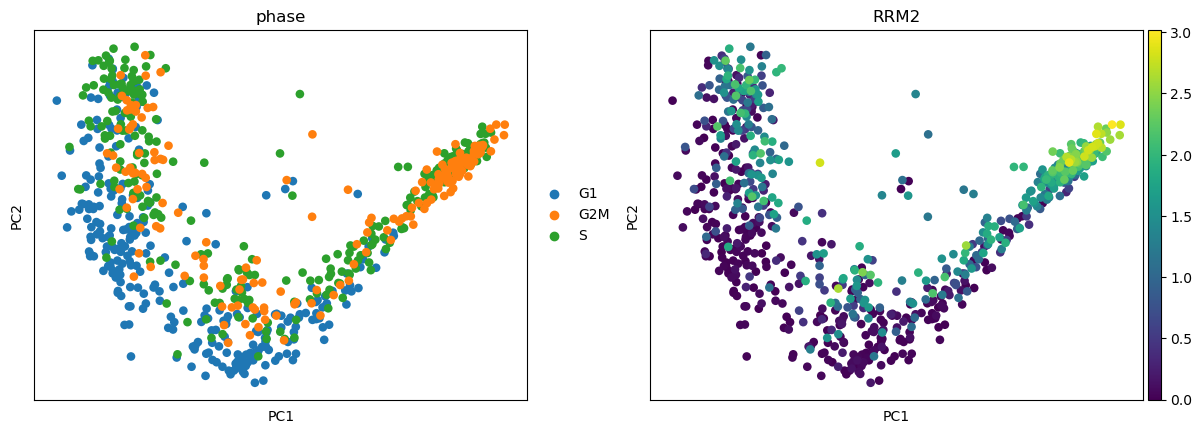

In [12]:
sc.pp.pca(adata_reconstruction)
sc.pl.pca(adata_reconstruction, color=['phase','RRM2'])

<h3>Creating an indicator matrix for the restriction of the optimization parameter.</h3> 
After each gradient ascent step, we will multiply the doubly stochastic matrix entry-wise by the indicator matrix, thus ensuring that each cell is only mapped to the bin associated with its cell cycle phase.

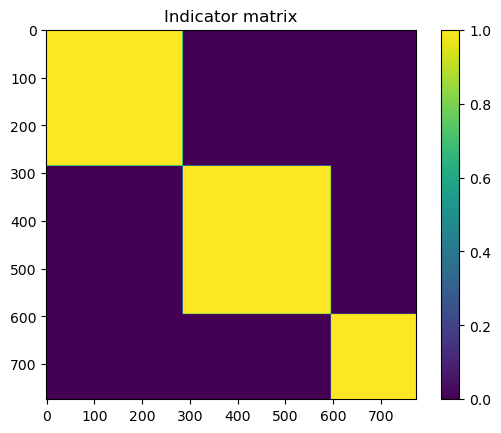

In [13]:
indicator_matrix = np.zeros((adata_reconstruction.n_obs,adata_reconstruction.n_obs))
crit_list = ['G1', 'G2M', 'S']
for i , j in enumerate(adata.obs["phase"]):
        indicator_matrix[i,:]=np.array(adata.obs["phase"]==j,dtype=int)
plt.imshow(indicator_matrix)
plt.title("Indicator matrix")
plt.colorbar()

In [14]:
E, E_rec = scPrisma.algorithms.reorder_indicator(adata.X,indicator_matrix, iterNum=100)

Iteration number: 0 function value= 0
Iteration number: 25 function value= 1.0024238721567282
Iteration number: 50 function value= 0.4230604884327066
Iteration number: 75 function value= 0.8306143545238976


The output of the reconstruction algorithm are two matrices:

'E', a doubly stochastic matrix
'E_rec', a permutation matrix, which is the rounded version of 'E'


In [15]:
adata_reconstruction2 = adata_reconstruction.copy()
sga_range = scPrisma.algorithms.e_to_range(E_rec)

To validate the results, we will plot the expression of a cell cycle-related gene along the reconstructed topology.

In [16]:
adata_reconstruction2  =adata_reconstruction2[sga_range,:]
adata_reconstruction2.obs['reconstruction']= sga_range

/tmp/ipykernel_10525/782587311.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_reconstruction2.obs['reconstruction']= sga_range


RRM2 expression <b>with</b> scPrisma reconstruction:

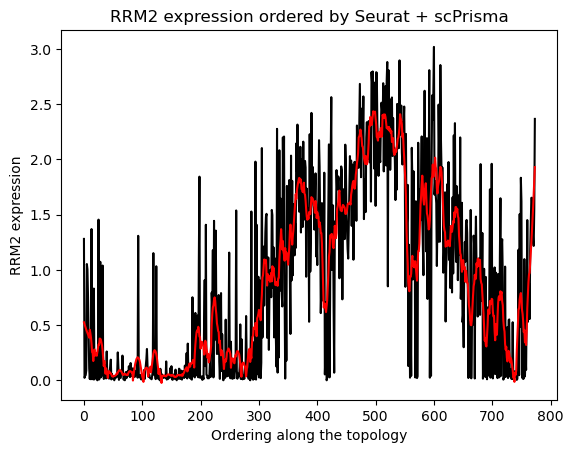

In [17]:
from scipy.signal import savgol_filter
plt.plot(adata_reconstruction2[:,"RRM2"].X[:,0], color='black')
plt.plot(savgol_filter(adata_reconstruction2[:,"RRM2"].X[:,0],19,2), color='r')
plt.ylabel('RRM2 expression')
plt.xlabel('Ordering along the topology')
plt.title('RRM2 expression ordered by Seurat + scPrisma')
plt.show()

RRM2 expression <b>without</b> scPrisma reconstruction (only division to bins according to the phases):

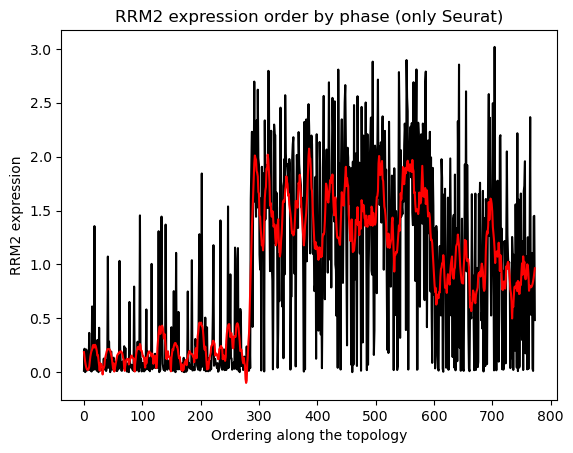

In [18]:
from scipy.signal import savgol_filter
plt.plot(adata_reconstruction[:,"RRM2"].X[:,0], color='black')
plt.plot(savgol_filter(adata_reconstruction[:,"RRM2"].X[:,0],19,2), color='r')
plt.ylabel('RRM2 expression')
plt.xlabel('Ordering along the topology')
plt.title('RRM2 expression order by phase (only Seurat)')
plt.show()

In [19]:
adata_reconstruction = adata_reconstruction[sga_range,:]

<h2> B- Enhancement workflow</h2>
<h3> B.1 Genes inference</h3>
Having obtained the reconstructed signal, either through the reconstruction problem or from prior knowledge, we will now identify the informative genes that are related to the desired signal.

Instead of using the exact gene inference algorithm described in the manuscript, we will select a fixed number of genes to retain based on their projection over the theoretical spectrum. This is similar to tuning the regularization parameter so that this number of genes is retained. Instead of identifying the group of genes that maximizes the overall projection on the theoretical spectrum, we will calculate the projection of each gene individually (after normalizing each gene using L2 normalization) and keep only the genes with the highest projection.

After that, we will validate that 'RRM2' expression is retained.

In [20]:
adata_enhancement = adata_reconstruction.copy()
adata_enhancement = adata_enhancement[:, adata_enhancement.var.highly_variable]
adata_enhancement

View of AnnData object with n_obs × n_vars = 774 × 7000
    obs: 'n_genes', 'n_counts', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'phase_colors'
    obsm: 'X_pca'
    varm: 'PCs'

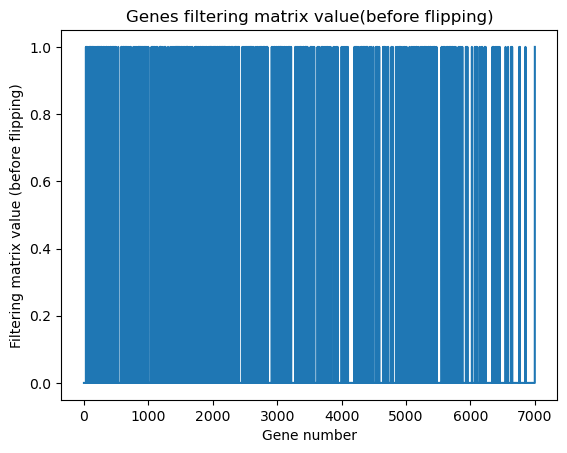

In [21]:
D = scPrisma.algorithms.filter_non_cyclic_genes_by_proj(adata_enhancement.X,n_genes=500)
adata_enhancement.X = adata_enhancement.X @ D
plt.plot(D.diagonal())
plt.xlabel("Gene number")
plt.ylabel("Filtering matrix value (before flipping)")
plt.title("Genes filtering matrix value(before flipping)")
plt.show()

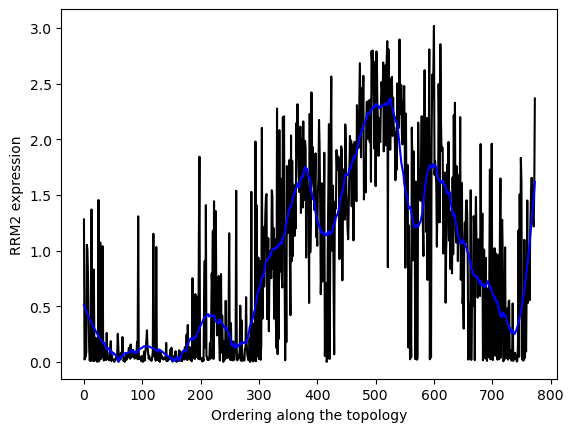

In [22]:
plt.plot(adata_enhancement[:,"RRM2"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"RRM2"].X[:,0],70,2), color='b')

plt.ylabel('RRM2 expression')
plt.xlabel('Ordering along the topology')
plt.show()

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_cpu_17_01/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


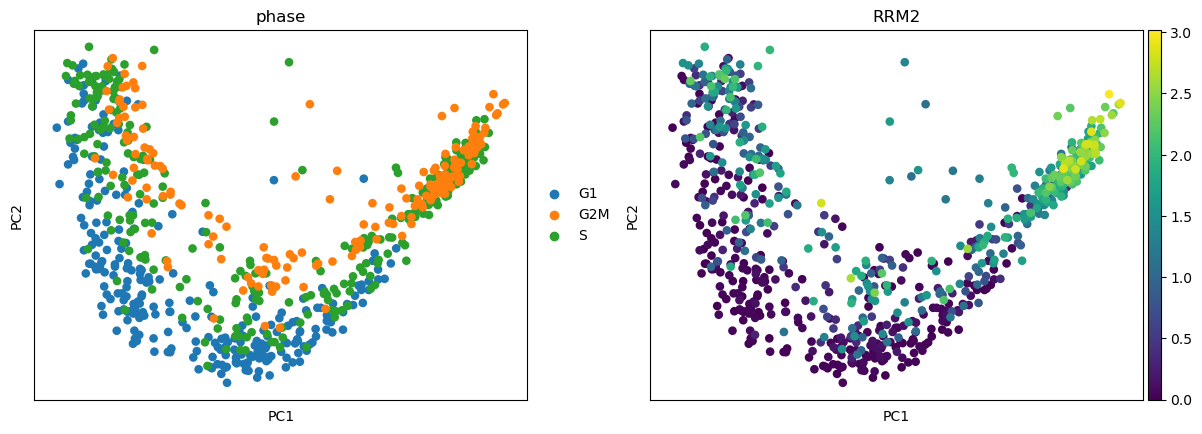

In [23]:
sc.pp.pca(adata_enhancement)
sc.pl.pca(adata_enhancement, color=['phase','RRM2'])

<h3> B.2 Cyclic enhancement</h3>
Having only the genes which are smooth over the inferred topology. We will clear from them the expression profiles which are not related to the cell cycle.

Here we need to tune the regularization parameter. Higher regularization will filter out more expression profiles which are not related to the reconstructed signal, which can also be validated using marker genes(such as 'RRM2').<br />
We highly recommend using as little regularization as possible to avoid overfitting.
We can also take a look at the filtering matrix and ensure that it is not zeros matrix.

Iteration number: 
1
function value: 
10930.012747649154
Iteration number: 
26
function value: 
18087.5768343375
Iteration number: 
51
function value: 
19260.569883952274
Iteration number: 
76
function value: 
19712.638580922725


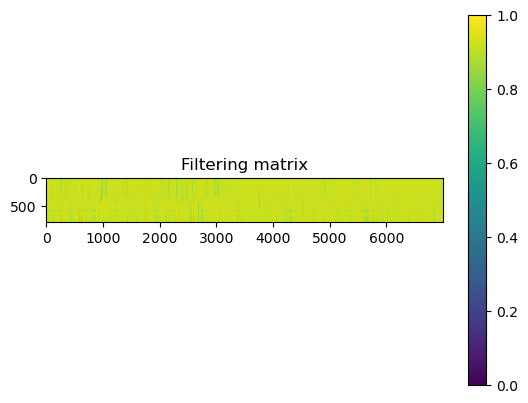

In [24]:
F = scPrisma.algorithms.enhancement_cyclic(adata_enhancement.X,regu=0.01,iterNum=100)

plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [25]:
adata_enhancement.X = adata_enhancement.X * F

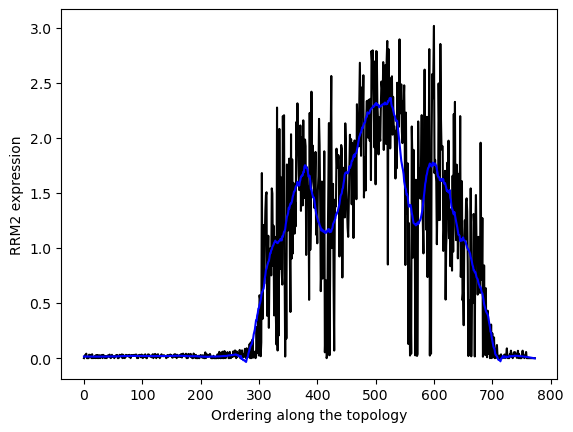

In [26]:
plt.plot(adata_enhancement[:,"RRM2"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_enhancement[:,"RRM2"].X[:,0],70,2), color='b')

plt.ylabel('RRM2 expression')
plt.xlabel('Ordering along the topology')
plt.show()

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_cpu_17_01/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


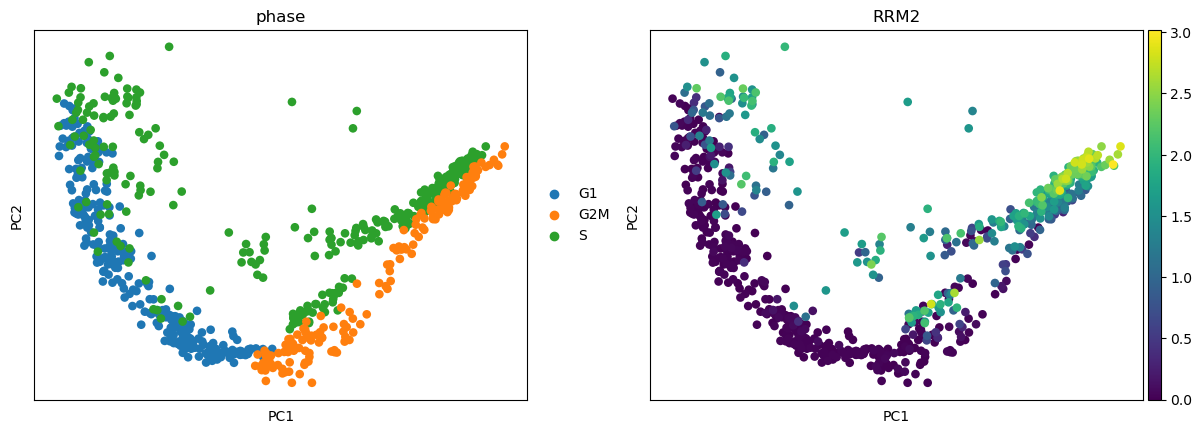

In [27]:
sc.pp.pca(adata_enhancement)
sc.pl.pca(adata_enhancement, color=['phase','RRM2'])

<h3>C.Signal Filtering</h3>
If insead of enhancing the reconstructed signal, we want to filter it out we can use cyclic filtering algorithm.

Here, we also have a regularization parameter, higher regularization will keep more expression profiles.

In [ ]:
adata_filtered = adata_reconstruction.copy()
F = scPrisma.algorithms.filtering_cyclic(adata_filtered.X,regu=0,iterNum=300)


starting filtering
25
th Iteration    Loss :: 
1066.5162573864973
50
th Iteration    Loss :: 
557.6425141916116
75
th Iteration    Loss :: 
368.4020705232723


In [ ]:
plt.imshow(F)
plt.title("Filtering matrix")
plt.colorbar()
plt.show()

In [ ]:
adata_filtered.X = adata_filtered.X * F


In [ ]:
plt.plot(adata_filtered[:,"RRM2"].X[:,0],color='black') #Peaktime at M
plt.plot(savgol_filter(adata_filtered[:,"RRM2"].X[:,0],70,2), color='b')

plt.ylabel('RRM2 expression')
plt.xlabel('Ordering along the topology')
plt.show()

In [ ]:
sc.pp.pca(adata_filtered)
sc.pl.pca(adata_filtered, color=['phase','RRM2'])